In [153]:
from Bio import SeqIO
import pandas as pd

def read_seq_from_fasta(fasta_file):
    for record in SeqIO.parse(fasta_file, "fasta"):
        return str(record.seq)

def load(protein, root_dir="gym_single"):
    fasta = f"./{root_dir}/fasta/{protein}.fasta"
    mutant = f"./{root_dir}/mutant/{protein}.csv"
    seq = read_seq_from_fasta(fasta)
    df = pd.read_csv(mutant)
    return seq, df

columns = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
vocab = {v : k for k, v in enumerate(columns)}

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def draw_heat_map(wild_sequence, df):
    # 示例突变数据及其对应的数字值
    # mutation_data = [("A3M", 0.1), ("A3Y", 0.5), ("B7R", 0.2), ("C10D", 0.8), ("C10H", 0.6), ("D15E", 0.9), ("E33K", 0.3)]
    mutation_data = [(each['mutant'], each['score']) for _, each in df.iterrows()]

    # 创建一个以位置为索引、20种天然氨基酸为列的空数据框
    columns = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    max_position = len(wild_sequence)
    min_position = 0
    index = range(min_position, max_position + 1)
    mutation_df = pd.DataFrame(index=index, columns=columns, dtype=float)

    # 填充突变后的氨基酸值
    for mutation, value in mutation_data:
        position = int(mutation[1:-1]) - 1
        amino_acid = mutation[-1]
        mutation_df.at[position, amino_acid] = value

    # 填充缺失值为0
    mutation_df.fillna(np.nan, inplace=True)

    # 填充突变后的氨基酸值，将野生型填充为0
    for mutation, value in mutation_data:
        position = int(mutation[1:-1])
        amino_acid = mutation[0]
        mutation_df.at[position, amino_acid] = 0


    # 创建热力图，使用"Greens"颜色映射
    plt.figure(figsize=(len(wild_sequence) // 2, 10), dpi=100)
    sns.heatmap(mutation_df.T, cmap='viridis', annot=True, fmt='.1f', cbar=True, cbar_kws={'label': 'Mutation Value'}, linewidths=0.1, linecolor='black')
    plt.title('Protein Mutation Heatmap')
    plt.xlabel('Mutation Position')
    plt.ylabel('Amino Acid')


    plt.show()


In [154]:
from ast import main
import random
import numpy as np
from typing import *
import torch


class SequenceMatrixBuilder:
    def __init__(self) -> None:
        self.eps = 1e-7

    def generate(
        self,
        wild_sequence: AnyStr,
        mutants: List[AnyStr],
        scores: List[float],
        vocab: Dict[AnyStr, int],
        special_tokens: List[str],
        offset: int = 1,
    ):
        # First, normalize the scores using min-max normalization
        scores = np.array(scores)
        scores = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))

        # Initialize the matrix with zeros
        matrix = np.zeros(shape=(len(vocab), len(wild_sequence)))

        # Initialize the mask with True
        mask = np.ones_like(matrix, dtype=bool)

        # Fill the matrix with mutant scores
        for i, mutant in enumerate(mutants):
            wt, idx, mt = mutant[0], int(mutant[1:-1]) - offset, mutant[-1]
            assert wild_sequence[idx] == wt
            matrix[vocab[mt], idx] = scores[i]
            mask[vocab[mt], idx] = False

        # Fill the matrix with wild-type scores
        for i, acid in enumerate(wild_sequence):
            matrix[vocab[acid], i] = np.mean(scores)
            mask[vocab[acid], i] = False

        # Get max sum values along the points (columns)
        max_sum = np.max(np.sum(matrix, axis=0))

        # Calcuate the difference between max sum and each point
        diff = max_sum - np.sum(matrix, axis=0)

        # Add the difference to the matrix
        for point in range(len(wild_sequence)):
            number_of_unmasked_acids = sum(mask[:, point])
            if diff[point] > 0:
                for acid in range(len(vocab)):
                    if mask[acid, point]:
                        matrix[acid, point] += diff[point] / number_of_unmasked_acids

        # matrix = np.log(matrix+1e-32)
        # matrix = self.softmax(matrix, axis=0)
        return matrix.T, mask.T

    def generate_v2(
        self, wild_sequence, mutants, scores, vocab, special_tokens, offset=1
    ):
        eps = 1e5
        sequence = wild_sequence
        sequence_matrix = np.zeros((len(vocab), len(sequence))) - eps  # [vocab, len]

        # Fill wild-type
        wild_type_score = np.mean(scores)
        for i, acid in enumerate(sequence):
            sequence_matrix[vocab[acid], i] = wild_type_score

        # Sort the values according index [0.1, 0.2, 0.3, 0.4, 0.5] -> [1,2,3,4,5]
        def index_sort(arr):
            sorted_values = np.sort(arr)
            index_values = []
            for item in arr:
                for index, value in enumerate(sorted_values):
                    if item == value:
                        index_values.append(index)
                        break
            return np.array(index_values)

        indices = index_sort(scores)

        # non-linear transformation indices(int) -> values(float), keep the order
        modal_values = np.linspace(1, 100, len(scores))
        modal_values = np.array([modal_values[i] for i in indices])

        # replace the values in the matrix
        for i, mutant in enumerate(mutants):
            wt, idx, mt = mutant[0], int(mutant[1:-1]) - offset, mutant[-1]
            sequence_matrix[vocab[mt], idx] = modal_values[i]

        # generate some values
        mask = sequence_matrix <= 1e-4
        sequence_matrix[mask] = -eps

        special_indices = [vocab[s] for s in special_tokens]
        for i in range(len(sequence_matrix)):
            for j in range(len(sequence_matrix[i])):
                if i in special_indices:
                    sequence_matrix[i, j] = -eps
                    mask[i, j] = True

        # return
        return sequence_matrix.T, mask.T

    @staticmethod
    def index_sort(arr: np.ndarray):
        sorted_values = np.sort(arr)
        index_values = []
        for item in arr:
            for index, value in enumerate(sorted_values):
                if item == value:
                    index_values.append(index)
                    break
        return np.array(index_values)

    @staticmethod
    def softmax(x, axis=None):
        e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
        return e_x / np.sum(e_x, axis=axis, keepdims=True)

    def order2value(self, order: np.ndarray, score: np.ndarray = None):
        # modal_values = np.linspace(1, 100, len(order))
        # modal_values = np.array([modal_values[i] for i in order])
        modal_values = order + 1
        sum_values = np.sum(modal_values).item()
        modal_values = np.log(modal_values / sum_values)
        return modal_values


def generate_matrix(sequence, mutants, scores, vocab, special_tokens, offset=1):
    eps = 1e5
    sequence_matrix = np.zeros((len(vocab), len(sequence))) - eps  # [vocab, len]

    # Fill wild-type
    wild_type_score = np.mean(scores)
    for i, acid in enumerate(sequence):
        sequence_matrix[vocab[acid], i] = wild_type_score

    # Sort the values according index [0.1, 0.2, 0.3, 0.4, 0.5] -> [1,2,3,4,5]
    def index_sort(arr):
        sorted_values = np.sort(arr)
        index_values = []
        for item in arr:
            for index, value in enumerate(sorted_values):
                if item == value:
                    index_values.append(index)
                    break
        return np.array(index_values)

    indices = index_sort(scores)

    # non-linear transformation indices(int) -> values(float), keep the order
    modal_values = np.linspace(1, 100, len(scores))
    modal_values = np.array([modal_values[i] for i in indices])

    # replace the values in the matrix
    for i, mutant in enumerate(mutants):
        wt, idx, mt = mutant[0], int(mutant[1:-1]) - offset, mutant[-1]
        sequence_matrix[vocab[mt], idx] = modal_values[i]

    # generate some values
    mask = sequence_matrix <= 1e-4
    sequence_matrix[mask] = -eps

    special_indices = [vocab[s] for s in special_tokens]
    for i in range(len(sequence_matrix)):
        for j in range(len(sequence_matrix[i])):
            if i in special_indices:
                sequence_matrix[i, j] = -eps
                mask[i, j] = True

    # return
    return sequence_matrix.T, modal_values, mask.T

In [155]:
protein = "GFP_AEQVI_Sarkisyan_2016"

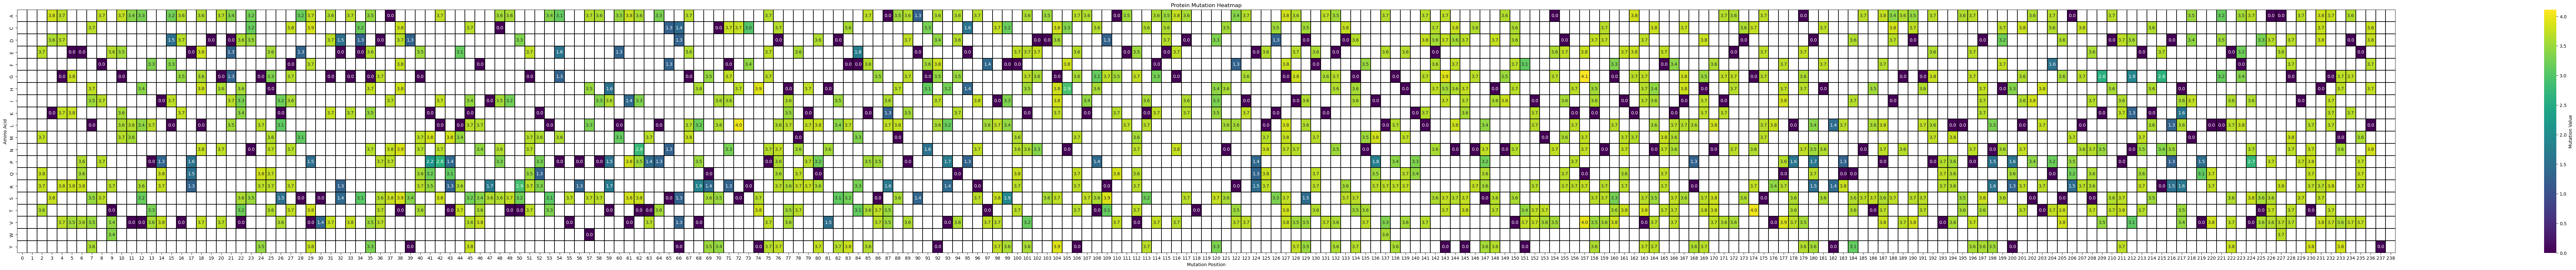

In [159]:
# 0 - 1 归一化
wild_seq, df = load(protein)
# df['score'] = (df['score'] - df['score'].min()) / (df['score'].max() - df['score'].min())
draw_heat_map(wild_seq, df)

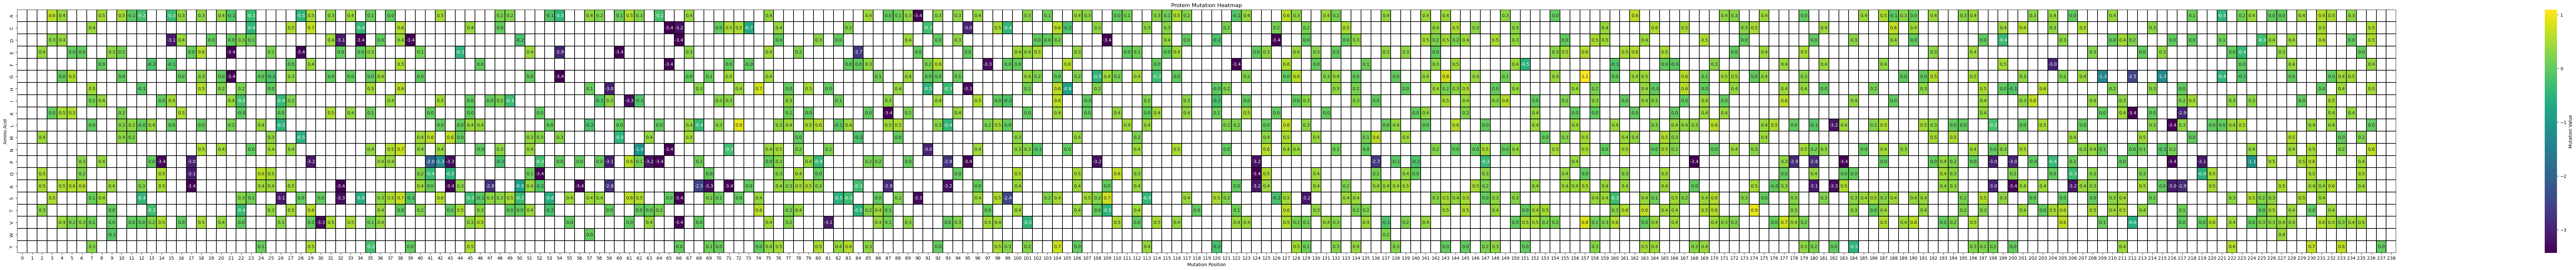

In [157]:
# z - score 归一化
wild_seq, df = load(protein)
df['score'] = (df['score'] - df['score'].mean()) / (df['score'].std())
draw_heat_map(wild_seq, df)

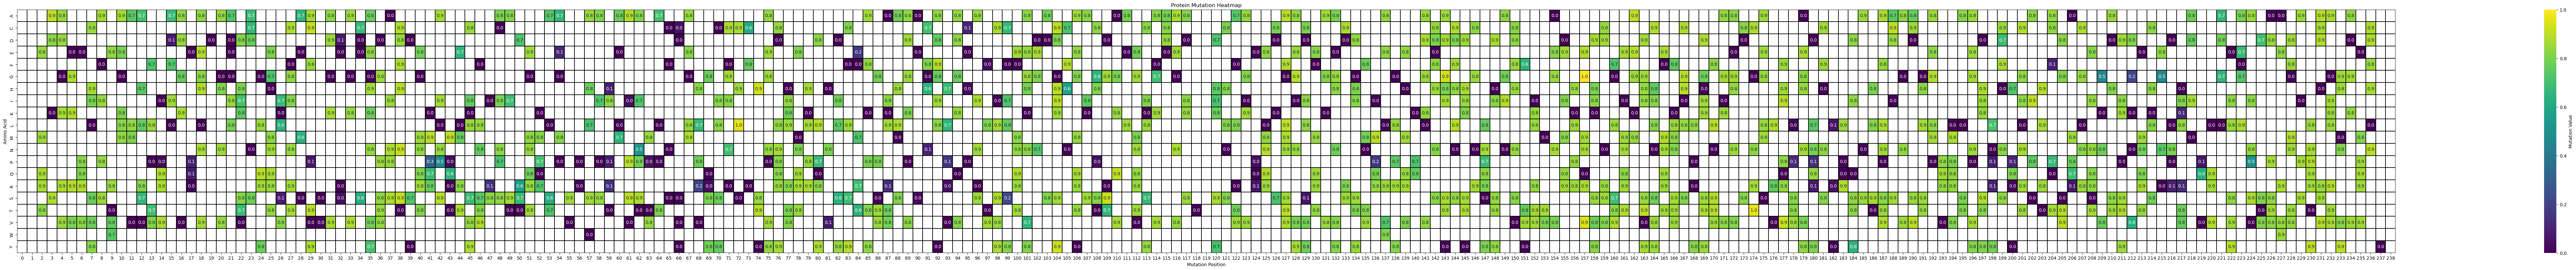

In [158]:
wild_seq, df = load(protein)
data, _ = SequenceMatrixBuilder().generate(
        wild_sequence = wild_seq,
        mutants = df['mutant'].values,
        scores = df['score'].values,
        vocab = vocab,
        special_tokens = [],
        offset = 1,
)
def fn(row):
    wt, idx, mt = row['mutant'][0], int(row['mutant'][1:-1]) - 1, row['mutant'][-1]
    return data[idx, vocab[mt]]
df['score'] = df.apply(fn, axis=1)
draw_heat_map(wild_seq, df)

In [139]:
df.shape

(1084, 2)

In [141]:
df.shape

(1084, 2)

In [144]:
data.shape

(238, 20)